# Tutorial: Basic Usage

This tutorial demonstrates how to use `spefit` to fit the SPE function to a numpy array of charge.

In [1]:
from spefit.dataset import Dataset
from spefit.pdf import PDFParameter, PDFSimultaneous, PMTSingleGaussian
from spefit.fitter import minimize_with_iminuit
from spefit.cost import BinnedNLL
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/Jason/Software/spefit/spefit/fitter.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


## The Dataset

Create a test dataset via inverse transform sampling from the single-photoelectron PDF for a simple PMT, at three seperate average illuminations λ (to utilise a simultaneous fit):

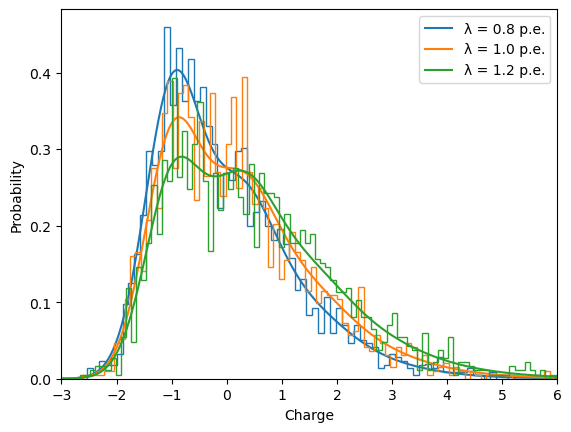

In [2]:
# Define the observation space
x = np.linspace(-5, 10, 10000)

# Define the model parameters
illuminations = [
    PDFParameter("lambda_0", 0.8, limits=(0, 5)),
    PDFParameter("lambda_1", 1.0, limits=(0, 5)),
    PDFParameter("lambda_2", 1.2, limits=(0, 5)),
]
eped = PDFParameter("eped", -1, limits=(-2, 2))
eped_sigma = PDFParameter("eped_sigma", 0.5, limits=(0, 2))
pe = PDFParameter("pe", 1.2, limits=(0, 3))
pe_sigma = PDFParameter("pe_sigma", 0.4, limits=(0, 2))

# Create the simultaneous fit model
pdf = PDFSimultaneous([
    PMTSingleGaussian(
        eped=eped, eped_sigma=eped_sigma,
        pe=pe, pe_sigma=pe_sigma,
        lambda_=illuminations[0],
    ),
    PMTSingleGaussian(
        eped=eped, eped_sigma=eped_sigma,
        pe=pe, pe_sigma=pe_sigma,
        lambda_=illuminations[1],
    ),
    PMTSingleGaussian(
        eped=eped, eped_sigma=eped_sigma,
        pe=pe, pe_sigma=pe_sigma,
        lambda_=illuminations[2],
    ),
])

# Plot the initial PDFs
fig, ax = plt.subplots()
ax.set_xlabel("Charge")
ax.set_ylabel("Probability")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

charge_arrays = []
for i, illumination in enumerate(illuminations):
    y = pdf(x, pdf.initial, i)  # Calculate PDF via the direct call to the PDF function
    c = np.random.choice(x, p=y / y.sum(), size=2000)  # Inverse transform sampling
    charge_arrays.append(c)
    
    # Plot the spectrum
    color = colors[i]
    ax.plot(x, y, color=color, label=f"λ = {illumination.initial} p.e.")
    ax.hist(c, bins=100, density=True, histtype='step', color=color)
    ax.set_xlim(-3, 6)

ax.legend()

## Prepare the Data

The first step in the fit process is to store the charge into the `ChargeContainer`, which prepares the charge for `spefit` (selecting the range of charge to fit, and creating this binned data for the binned negative log-likelihood and least-sqaures cost approaches. 

In [3]:
datasets = [Dataset(c, n_bins=100, range_=(-3, 6)) for c in charge_arrays]

## Perform the Fit

The `PDF` class defines the description of the SPE PDF, and handles everything to do with the multi-illumination simulateous fit.

The `Cost` class defines the function to be minimised, given a `PDF` class and the data (contained in the `ChargeContainer`), to obtain the best-fit parameters. `spefit` provides three minimisation approaches, described by the `Cost` subclasses:
1. Unbinned negative log-likelihood (`UnbinnedNLL`)
2. Binned negative log-likelihood (`BinnedNLL`)
3. Least-squares Chi-squared (`LeastSquares`)

Due to the Poisson nature of the counts in each bin, it is recommended to use the NLL methods. The `UnbinnedNLL` can be slower than `BinnedNLL` due to the evaluation of each charge, however it ensures no features are lost by a poor binning of the charges. Here we will demonstrate the `BinnedNLL` cost method.

In [4]:
cost = BinnedNLL(pdf, datasets)  # Create the Cost class to be minimised
values, errors = minimize_with_iminuit(cost)

## Demonstrate Result

With the returned values from the fit, we can plot the resulting fit curve and obtain the score of the fit from the `Cost` class:

p-value = 0.26, reduced-chi2 = 1.05

eped_sigma = 0.50 ± 0.02
pe_sigma = 0.45 ± 0.11
lambda_1 = 0.95 ± 0.14
pe = 1.20 ± 0.13
lambda_0 = 0.80 ± 0.12
lambda_2 = 1.20 ± 0.16
eped = -0.98 ± 0.05


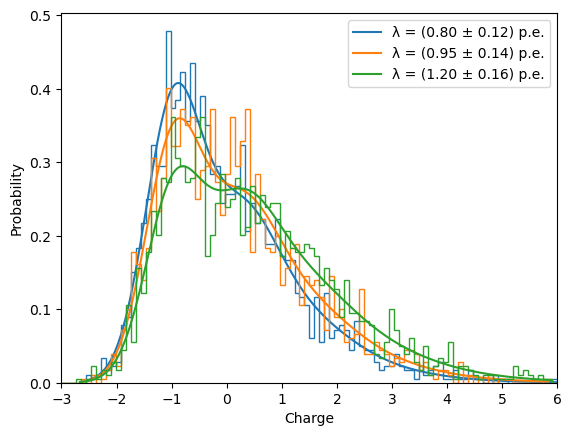

In [5]:
values_array = np.array(list(values.values()))
_, ax = plt.subplots()
ax.set_xlabel("Charge")
ax.set_ylabel("Probability")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in range(len(illuminations)):
    fit_x = np.linspace(datasets[i].values.min(), datasets[i].values.max(), 1000)
    fit_y = pdf(fit_x, values_array, i)  # Pass the values to the PDF class to obtain the best-fit curve for each illumination i
    
    lambda_ = values[f'lambda_{i}']
    lambda_err = errors[f'lambda_{i}']
    
    color = colors[i]
    ax.plot(fit_x, fit_y, color=color, label=f"λ = ({lambda_:.2f} ± {lambda_err:.2f}) p.e.")
    ax.hist(
        datasets[i].between, weights=datasets[i].hist, bins=datasets[i].edges,
        density=True, histtype='step', color=color
    )
    ax.set_xlim(-3, 6)
    
ax.legend()

print(f"p-value = {cost.p_value(values_array):.2f}, reduced-chi2 = {cost.reduced_chi2(values_array):.2f}\n")

for param in values.keys():
    print(f"{param} = {values[param]:.2f} ± {errors[param]:.2f}")